<center>
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/Logos/organization_logo/organization_logo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>


<h1>Capstone Project - The Battle of Neighborhoods:</h1>
<h1>Finding the Optimal Location for a Veterinary Clinic in Toronto</h1>

<h4 id="Section_1"> Find the data source on the web, scrape the page and load the postal code / borough / neighbourhood data to a dataframe. </h4>


In [1]:
import pandas as pd
import requests

# Set options to display all rows and all columns without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Get the contents of the Wikipedia webpage with Toronto FSA codes
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html = requests.get(url).content
df_list = pd.read_html(html)

# Load the table with Postal Codes, Boroughs and Neighbourhoods to the dataframe
#  (two tables on the page, get the first one)
df_neighbourhoods = df_list[0]

# Assign column names; columns are initially unnamed
df_neighbourhoods.columns = ['col0', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8']

# Concatenate, i.e. append
df_neighbourhoods = pd.concat([df_neighbourhoods.col0,df_neighbourhoods.col1,df_neighbourhoods.col2,df_neighbourhoods.col3,df_neighbourhoods.col4,df_neighbourhoods.col5,df_neighbourhoods.col6,df_neighbourhoods.col7,df_neighbourhoods.col8])

# Assign column names
df_neighbourhoods = pd.DataFrame({'ind':df_neighbourhoods.index, 'whole_str':df_neighbourhoods.values})

# Drop the index column
df_neighbourhoods = df_neighbourhoods.drop('ind', 1)

# Build FSA as the first 3 characters of the concatenated string
df_neighbourhoods["PostalCode"] = df_neighbourhoods["whole_str"].str[:3]

# Build Borough as the substring beginning with the 4th character of the concatenated string and ending before the left parenthesis
df_neighbourhoods["Borough"] = df_neighbourhoods["whole_str"].str.split('(').str[0].str[3:]

# Build Neighbourhoods_temp as the substring beginning after the left parenthesis
df_neighbourhoods["Neighbourhood_temp"] = df_neighbourhoods["whole_str"].str.split('(').str[1]

# Build Neighbourhoods as the substring of Neighbourhoods_temp ending before the right parenthesis
df_neighbourhoods["Neighbourhood"] = df_neighbourhoods["Neighbourhood_temp"].str.split(')').str[0]

# Replace the delimiter: 'comma+space' instead 'space+slash+space' 
df_neighbourhoods["Neighbourhood"] = df_neighbourhoods["Neighbourhood"].str.replace(' / ', ', ')

# Remove rows where FSA is not assigned to a Borough
df_neighbourhoods = df_neighbourhoods[df_neighbourhoods["Borough"] != 'Not assigned']

# Drop the unneeded columns
df_neighbourhoods.drop(['whole_str', 'Neighbourhood_temp'], axis=1, inplace=True)

# Reset the index
df_neighbourhoods.reset_index(drop=True, inplace=True)

# Use the .shape method to print the number of rows in the dataframe: 
df_neighbourhoods.shape

(103, 3)

<h4 id="Section_1"> Display the dataframe: </h4>

In [2]:
# Display the result
df_neighbourhoods.head()

,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


<h4 id="Section_1"> Add latitude and longitude to the dataframe: </h4>

In [3]:
!pip install pgeocode

import pgeocode
nomi = pgeocode.Nominatim('ca')

latitude = []
longitude = []
for value in df_neighbourhoods["PostalCode"]:
    location = nomi.query_postal_code(value)
    latitude.append(location.latitude)
    longitude.append(location.longitude)
df_neighbourhoods["Latitude"] = latitude
df_neighbourhoods["Longitude"] = longitude

# Remove rows where lat or long are not found
df_neighbourhoods = df_neighbourhoods[pd.isnull(df_neighbourhoods["Latitude"]) == False]
df_neighbourhoods = df_neighbourhoods[pd.isnull(df_neighbourhoods["Longitude"]) == False]

# Reset the index
df_neighbourhoods.reset_index(drop=True, inplace=True)

df_neighbourhoods.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.8113,-79.1930
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.7878,-79.1564
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.7678,-79.1866
3,M1G,Scarborough,Woburn,43.7712,-79.2144
4,M1H,Scarborough,Cedarbrae,43.7686,-79.2389


<h4 id="Section_1"> Create a new dataframe with Foursquare queries: </h4>

In [4]:
df_foursquare_queries = pd.DataFrame(columns=['PostalCode', 'Borough', 'Latitude', 'Longitude', 'FSquery'])

CLIENT_ID = '1UJCVJ3INGBNBAIP4HGIA0PY0ZWYG1IES5NKIX0XJW1UCEEN'
CLIENT_SECRET = 'AD33OJ12KFJOH40USMEPX1AZ1ELNJHV3EFPP1IHXT0GVG5BH'
VERSION = '20210329'
RADIUS=str(10000)
LIMIT=str(100)
QUERY='veterinarian'

for i in range(len(df_neighbourhoods)) :
    FSquery = "https://api.foursquare.com/v2/venues/explore?&client_id=" + CLIENT_ID + "&client_secret=" + CLIENT_SECRET + "&v=" + VERSION + "&ll=" + str(df_neighbourhoods.iloc[i,3]) + "," + str(df_neighbourhoods.iloc[i,4]) + "&radius=" + RADIUS + "&limit=" + LIMIT + "&query=" + QUERY
    df_foursquare_queries.loc[i] = [df_neighbourhoods.iloc[i,0], df_neighbourhoods.iloc[i,1], df_neighbourhoods.iloc[i,3], df_neighbourhoods.iloc[i,4], FSquery]

df_foursquare_queries.head()


,PostalCode,Borough,Latitude,Longitude,FSquery
0,M1B,Scarborough,43.8113,-79.1930,"https://api.foursquare.com/v2/venues/explore?&client_id=1UJCVJ3INGBNBAIP4HGIA0PY0ZWYG1IES5NKIX0XJW1UCEEN&client_secret=AD33OJ12KFJOH40USMEPX1AZ1ELNJHV3EFPP1IHXT0GVG5BH&v=20210329&ll=43.8113,-79.193&radius=10000&limit=100&query=veterinarian"
1,M1C,Scarborough,43.7878,-79.1564,"https://api.foursquare.com/v2/venues/explore?&client_id=1UJCVJ3INGBNBAIP4HGIA0PY0ZWYG1IES5NKIX0XJW1UCEEN&client_secret=AD33OJ12KFJOH40USMEPX1AZ1ELNJHV3EFPP1IHXT0GVG5BH&v=20210329&ll=43.7878,-79.1564&radius=10000&limit=100&query=veterinarian"
2,M1E,Scarborough,43.7678,-79.1866,"https://api.foursquare.com/v2/venues/explore?&client_id=1UJCVJ3INGBNBAIP4HGIA0PY0ZWYG1IES5NKIX0XJW1UCEEN&client_secret=AD33OJ12KFJOH40USMEPX1AZ1ELNJHV3EFPP1IHXT0GVG5BH&v=20210329&ll=43.7678,-79.1866&radius=10000&limit=100&query=veterinarian"
3,M1G,Scarborough,43.7712,-79.2144,"https://api.foursquare.com/v2/venues/explore?&client_id=1UJCVJ3INGBNBAIP4HGIA0PY0ZWYG1IES5NKIX0XJW1UCEEN&client_secret=AD33OJ12KFJOH40USMEPX1AZ1ELNJHV3EFPP1IHXT0GVG5BH&v=20210329&ll=43.7712,-79.2144&radius=10000&limit=100&query=veterinarian"
4,M1H,Scarborough,43.7686,-79.2389,"https://api.foursquare.com/v2/venues/explore?&client_id=1UJCVJ3INGBNBAIP4HGIA0PY0ZWYG1IES5NKIX0XJW1UCEEN&client_secret=AD33OJ12KFJOH40USMEPX1AZ1ELNJHV3EFPP1IHXT0GVG5BH&v=20210329&ll=43.7686,-79.2389&radius=10000&limit=100&query=veterinarian"


<h4 id="Section_1"> Create a new dataframe, run Foursquare queries one by one and load the results in the new dataframe. But first, download all the dependencies</h4>

In [5]:
!conda install -c conda-forge folium=0.5.0 --yes 

import json 

#import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors


Solving environment: ...working... done

# All requested packages already installed.



<h4 id="Section_1"> Loop through the dataframe with Foursquare queries, pull the results, flatten the json dataset and load into the neighbourhoods/venues dataframe:</h4>

In [6]:
import urllib.request #, json 

# Function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# New dataframe
df_neighbourhoods_venues = pd.DataFrame(columns=['PostalCode', 'Borough', 'Latitude', 'Longitude', 'VenueName', 'VenueCategory', 'VenueLat','VenueLong'])

for i in range(len(df_foursquare_queries)) :
    with urllib.request.urlopen(df_foursquare_queries.iloc[i,4]) as url:
        df_venue_data_json = json.loads(url.read().decode()) 
        df_venue_data = pd.DataFrame(df_venue_data_json)
                
        venues_temp = df_venue_data['response']['groups'][0]['items']
        venues_temp_flatten = pd.json_normalize(venues_temp) # flatten JSON
                        
        # filter columns
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
        venues_temp_flatten = venues_temp_flatten.loc[:, filtered_columns]
                
        venues_temp_flatten['venue.categories'] = venues_temp_flatten.apply(get_category_type, axis=1)
        
        # clean columns
        venues_temp_flatten.columns = [col.split(".")[-1] for col in venues_temp_flatten.columns]
               
        for j in range(len(venues_temp_flatten)) :
            df_neighbourhoods_venues = df_neighbourhoods_venues.append({'PostalCode':df_foursquare_queries.iloc[i,0], 'Borough':df_foursquare_queries.iloc[i,1], 'Latitude':df_foursquare_queries.iloc[i,2], 'Longitude':df_foursquare_queries.iloc[i,3], 'VenueName':venues_temp_flatten.iloc[j,0], 'VenueCategory':venues_temp_flatten.iloc[j,1], 'VenueLat':df_foursquare_queries.iloc[i,2], 'VenueLong':venues_temp_flatten.iloc[j,3]}, ignore_index=True)
            

df_neighbourhoods_venues.head()


,PostalCode,Borough,Latitude,Longitude,VenueName,VenueCategory,VenueLat,VenueLong
0,M1B,Scarborough,43.8113,-79.193,West Hill Animal Clinic,Veterinarian,43.8113,-79.138002
1,M1B,Scarborough,43.8113,-79.193,Markham Road Animal Hospital,Veterinarian,43.8113,-79.229159
2,M1B,Scarborough,43.8113,-79.193,Whites Road Animal Hospital,Veterinarian,43.8113,-79.122314
3,M1B,Scarborough,43.8113,-79.193,Ashcott Veterinary Clinic,Veterinarian,43.8113,-79.290771
4,M1B,Scarborough,43.8113,-79.193,Markham Veterinary Clinic,Veterinarian,43.8113,-79.238510


<h4 id="Section_1"> Count the venues by FSA: </h4>

In [7]:
venue_count = df_neighbourhoods_venues['PostalCode'].value_counts()
df_venue_count = pd.DataFrame({'PostalCode':venue_count.index, 'VenueCount':venue_count.values})

df_neighbourhoods_short = df_neighbourhoods[['PostalCode', 'Latitude', 'Longitude']]

df_venue_count = df_venue_count.merge(df_neighbourhoods_short)
df_venue_count.head()

,PostalCode,VenueCount,Latitude,Longitude
0,M6C,44,43.6915,-79.4307
1,M4P,44,43.7135,-79.3887
2,M6G,43,43.6683,-79.4205
3,M6E,43,43.6889,-79.4507
4,M5N,43,43.7113,-79.4195


<h4 id="Section_1"> Plot the clusters on the map: </h4>

In [8]:
# create map of Toronto using latitude and longitude values

import pgeocode
nomi = pgeocode.Nominatim('ca')

import folium
from folium.features import DivIcon

zoom_latitude = 43.716436
zoom_longitude = -79.381602

map_toronto = folium.Map(location=[zoom_latitude, zoom_longitude], zoom_start=11.4)

for i in range(len(df_venue_count)) :
    if df_venue_count.iloc[i,1] > 40:
        ccolour = "#ff0000"
    if 31 <= df_venue_count.iloc[i,1] <= 40:
        ccolour = "#ffa500"
    if 21 <= df_venue_count.iloc[i,1] <= 30:
        ccolour = "#ffff00" 
    if 11 <= df_venue_count.iloc[i,1] <= 20:
        ccolour = "#5ec765"
    if 0 <= df_venue_count.iloc[i,1] <= 10:
        ccolour = "#0080ff"        
    
    folium.Circle(
        location=[df_venue_count.iloc[i,2], df_venue_count.iloc[i,3]], 
        radius=500, 
        color=ccolour,
        fill=True
    ).add_child(folium.Popup(str(df_venue_count.iloc[i,0])+": "+str(df_venue_count.iloc[i,1]))).add_to(map_toronto)

    
    folium.map.Marker(
        [df_venue_count.iloc[i,2], df_venue_count.iloc[i,3]],
        icon=DivIcon(
        icon_size=(1,1),
        icon_anchor=(7,7),
        html='<div style="font-size: 7pt">%s</div>' % df_venue_count.iloc[i,1],
        )
    ).add_to(map_toronto)

map_toronto

<h4 id="Section_1"> Download Census data (population by FSA), load in to a dataframe and merge with venue count data frame </h4>


In [9]:
#import pandas as pd
path='https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Tables/File.cfm?T=1201&SR=1&RPP=9999&PR=0&CMA=0&CSD=0&S=22&O=A&Lang=Eng&OFT=CSV'
df_fsa_population = pd.read_csv(path, encoding= 'unicode_escape')

df_fsa_population.columns = ['PostalCode', 'PostalName', 'ProvinceOrTerritory', 'IncompletelyEnumeratedIndianReservesAndSettlements', 'Population', 'PrivateDwellings', 'PrivateDwellingsUsualResidents']

# Drop the unneeded columns
df_fsa_population.drop(['PostalName', 'ProvinceOrTerritory', 'IncompletelyEnumeratedIndianReservesAndSettlements', 'PrivateDwellings', 'PrivateDwellingsUsualResidents'], axis=1, inplace=True)

df_fsa_population = df_fsa_population[df_fsa_population.PostalCode.str[0] == 'M']

# Reset the index
df_fsa_population.reset_index(drop=True, inplace=True)

df_fsa_population_venue_count = df_venue_count.merge(df_fsa_population)
df_fsa_population_venue_count.head()

,PostalCode,VenueCount,Latitude,Longitude,Population
0,M6C,44,43.6915,-79.4307,24596.0
1,M4P,44,43.7135,-79.3887,20039.0
2,M6G,43,43.6683,-79.4205,32086.0
3,M6E,43,43.6889,-79.4507,38041.0
4,M5N,43,43.7113,-79.4195,16610.0


<h4 id="Section_1"> Calculate Population/Venue ratio and normalize the values: </h4>

In [10]:
from sklearn import preprocessing

df_fsa_population_venue_count['PopulationPerVenue'] = df_fsa_population_venue_count['Population'] / df_fsa_population_venue_count['VenueCount']

x = df_fsa_population_venue_count[['PopulationPerVenue']]
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dataset = pd.DataFrame(x_scaled)
dataset[['PostalCode', 'Latitude', 'Longitude']] = df_fsa_population_venue_count[['PostalCode', 'Latitude', 'Longitude']]

dataset.columns = ['PopulationPerVenueNorm', 'PostalCode', 'Latitude', 'Longitude']

df_fsa_population_venue_count[['PostalCode', 'Latitude', 'Longitude', 'PopulationPerVenueNorm']] = dataset[['PostalCode', 'Latitude', 'Longitude', 'PopulationPerVenueNorm']]

df_fsa_population_venue_count['Population'] = df_fsa_population_venue_count['Population'].astype(int)

df_fsa_population_venue_count.head()

,PostalCode,VenueCount,Latitude,Longitude,Population,PopulationPerVenue,PopulationPerVenueNorm
0,M6C,44,43.6915,-79.4307,24596,559.000000,0.039958
1,M4P,44,43.7135,-79.3887,20039,455.431818,0.032555
2,M6G,43,43.6683,-79.4205,32086,746.186047,0.053338
3,M6E,43,43.6889,-79.4507,38041,884.674419,0.063237
4,M5N,43,43.7113,-79.4195,16610,386.279070,0.027612


<h4 id="Section_1"> Create a boxplot to show the distribution and identify outliers: </h4>

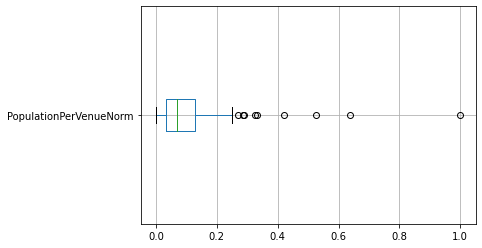

In [11]:
boxplot = df_fsa_population_venue_count.boxplot(column=['PopulationPerVenueNorm'], vert=False)

<h4 id="Section_1"> Create the map of Toronto using latitude and longitude values, this time with colour coded markers based on the normalized values of Population / Venue ratio: </h4>

In [12]:
zoom_latitude = 43.716436
zoom_longitude = -79.381602

map_toronto = folium.Map(location=[zoom_latitude, zoom_longitude], zoom_start=11.4)

for i in range(len(df_fsa_population_venue_count)) :
    if df_fsa_population_venue_count.iloc[i,6] > 0.8:
        ccolour = "#ff0000"
    if 0.6 < df_fsa_population_venue_count.iloc[i,6] <= 0.8:
        ccolour = "#ffa500"
    if 0.4 < df_fsa_population_venue_count.iloc[i,6] <= 0.6:
        ccolour = "#ffff00" 
    if 0.2 < df_fsa_population_venue_count.iloc[i,6] <= 0.4:
        ccolour = "#5ec765"
    if 0 <= df_fsa_population_venue_count.iloc[i,6] <= 0.2:
        ccolour = "#0080ff"        
    
    folium.Circle(
        location=[df_fsa_population_venue_count.iloc[i,2], df_venue_count.iloc[i,3]], 
        radius=500, 
        color=ccolour,
        fill=True
    ).add_child(folium.Popup(str(df_fsa_population_venue_count.iloc[i,0])+": "+str(df_fsa_population_venue_count.iloc[i,1]))).add_to(map_toronto)

    
    folium.map.Marker(
        [df_fsa_population_venue_count.iloc[i,2], df_fsa_population_venue_count.iloc[i,3]],
        icon=DivIcon(
        icon_size=(1,1),
        icon_anchor=(7,7),
        html='<div style="font-size: 7pt">%s</div>' % df_fsa_population_venue_count.iloc[i,1],
        )
    ).add_to(map_toronto)

map_toronto

<h4 id="Section_1"> Display the dataframe sorted by 'PopulationPerVenue' in descending order: </h4>

In [13]:
df_fsa_population_venue_count.sort_values(by='PopulationPerVenue', ascending=False)

,PostalCode,VenueCount,Latitude,Longitude,Population,PopulationPerVenue,PopulationPerVenueNorm
100,M9V,4,43.7432,-79.5876,55959,13989.750000,1.000000
99,M1C,4,43.7878,-79.1564,35626,8906.500000,0.636645
96,M1B,9,43.8113,-79.1930,66108,7345.333333,0.525051
98,M1E,8,43.7678,-79.1866,46943,5867.875000,0.419441
97,M3N,9,43.7568,-79.5210,41958,4662.000000,0.333244
86,M1V,12,43.8177,-79.2819,54680,4556.666667,0.325715
93,M9W,10,43.7144,-79.5909,40684,4068.400000,0.290813
101,M9L,3,43.7598,-79.5565,11950,3983.333333,0.284732
69,M2N,20,43.7673,-79.4111,75897,3794.850000,0.271259
83,M1P,13,43.7612,-79.2707,45571,3505.461538,0.250574


<h4 id="Section_1"> Develop the linear regression model and create the scatter plot: </h4>

[-0.0421023]
[[5.68543931e-06]]


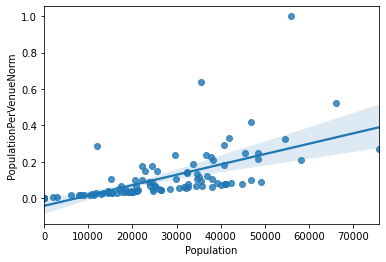

In [14]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm

X = df_fsa_population_venue_count[['Population']]
Y = df_fsa_population_venue_count[['PopulationPerVenueNorm']]

lm.fit(X,Y)

Yhat=lm.predict(X)
Yhat[0:5]   

print(lm.intercept_)
print(lm.coef_)

import seaborn as sns

sns.regplot(x="Population",
            y="PopulationPerVenueNorm", 
            data=df_fsa_population_venue_count);